In [1]:
import pickle
import random
import networkx as nx
import numpy as np
import polars as pl
from nx_landmarks import landmarks

In [2]:
G = nx.read_adjlist('Data/com-dblp_ungraph.csv')
G = nx.convert_node_labels_to_integers(G)

In [3]:
G.number_of_nodes()

317080

In [4]:
k = 500
nodes = list(G.nodes())
sampled = random.sample(nodes, min(k, len(nodes)))
closeness_app = {v: 0 for v in nodes}
for s in sampled:
    lengths = nx.single_source_shortest_path_length(G, s)
    for v, d in lengths.items():
        closeness_app[v] += d
        
closeness_app = {v: (k / closeness_app[v]) if closeness_app[v] > 0 else 0 for v in nodes}
test = {k: closeness_app[k] for k in range(1000)}

from tqdm import tqdm
nodes = list(G.nodes)
n_nodes_ex = G.number_of_nodes()-1
closeness = {k:0 for k in nodes[:1000]}
for node in tqdm(nodes[:1000]):
    closeness[node] = n_nodes_ex/sum(dict(nx.shortest_path_length(G, source=node)).values()) 

subtracted = [abs(x - y) for x, y in zip(list(closeness.values()),list(test.values()))]
np.max(subtracted)/1

100%|██████████| 1000/1000 [04:10<00:00,  4.00it/s]


np.float64(0.0032888354542353615)

In [62]:
from copy import deepcopy
landmarks_arr = [
    landmarks(G,10,'rand',1),
    landmarks(G,10,'deg',1),
    landmarks(G,10,'close',1),
    landmarks(G,10,'between',1),
]
print('Done...')
for D in landmarks_arr:
    D.get_landmarks()
original_arr = [deepcopy(D) for D in landmarks_arr]

Done...


In [53]:
original_arr = [deepcopy(D) for D in landmarks_arr]

In [39]:
def sample_random_pairs(G,n = 1):
    choice = np.random.choice(G.nodes(),2*n)
    pairs =[]
    for i in range(n):
        idx = 2*i
        pairs.append(((choice[idx]),choice[idx+1]))
    return pairs

def average_error(D,pairs,true):
    estimations = []
    for pair in pairs:
        estimations.append(D.shortest_path_estimation_upper_bound(pair[0],pair[1]))
    errors = [(e-t)/t for e,t in zip(estimations,true)]
    return sum(errors)/len(errors)

def average_LU_ratio(D,pairs):
    ratio = []
    for pair in pairs:
        ratio.append(D.shortest_path_estimation_lower_bound(pair[0],pair[1])/D.shortest_path_estimation_upper_bound(pair[0],pair[1]))
    return np.average(np.array(ratio))

In [63]:
def experiment_setup(G,landmarks:list)->list:
    node_sample = sample_random_pairs(G, 2000)
    true = [nx.shortest_path_length(G, source=s,target=t) for s,t in node_sample]
    results_rel_error = [[] for D in landmarks]
    results_lu_ratio = [[] for D in landmarks]
    
    for n_landm in tqdm(range(50,500,10)):
        for idx,D in enumerate(landmarks):
            results_rel_error[idx].append((average_error(D,node_sample,true),len(D.landmarks)))
            results_lu_ratio[idx].append((average_LU_ratio(D,node_sample),len(D.landmarks)))
            D.add_landmarks(10)
    return results_rel_error,results_lu_ratio

In [64]:
results_rel_error,results_lu_ratio = experiment_setup(G,original_arr)

100%|██████████| 45/45 [11:03<00:00, 14.75s/it]


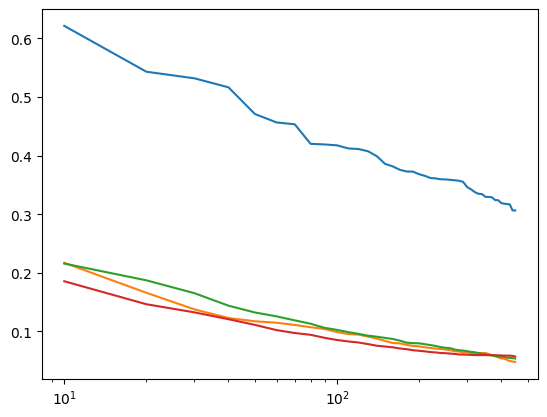

In [66]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
for result in results_rel_error:
    x = [a[1] for a in result]
    y = [a[0] for a in result]
    ax.plot(x,y)
ax.set_xscale('log')
# ax.set_aspect('equal')
plt.show()